In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pylab as plt

Original paper: https://yakovbh.net.technion.ac.il/files/2018/08/optimizers-curse04.pdf

Derivation of maths: https://stats.stackexchange.com/questions/381212/distribution-of-maximum-of-normally-distributed-random-variables

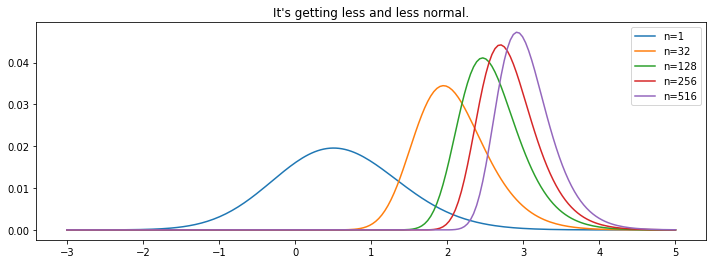

In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pylab as plt

plt.figure(figsize=(12, 4))
x = np.linspace(-3, 5, 200)
for n in [1, 32, 128, 256, 516]:
  s = n * norm.pdf(x) * norm.cdf(x)**n
  plt.plot(x, s/s.sum(), label=f"n={n}")

plt.legend()
plt.title("It's getting less and less normal.");

Let us see if we might actually replicate this. Let's even not use the `random_state` as a hyperparameter.

In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import make_scorer, accuracy_score
from sklego.datasets import fetch_creditcard
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

X, y = fetch_creditcard(return_X_y=True)
X.shape, y.shape

((284807, 29), (284807,))

In [50]:
@ignore_warnings(category=ConvergenceWarning)
def run_grid(settings=10, cv=2):
    settings = {
        'C': np.linspace(.01, 100.0, settings)
    }

    grid = GridSearchCV(
        estimator=LogisticRegression(class_weight="balanced"), 
        cv=cv,
        n_jobs=-1,
        param_grid=settings, 
        scoring={"acc": make_scorer(accuracy_score)},
        refit="acc"
    )

    return pd.DataFrame(grid.fit(X, y).cv_results_).sort_values("rank_test_acc");

In [51]:
df_plot_normal = run_grid(settings=20)

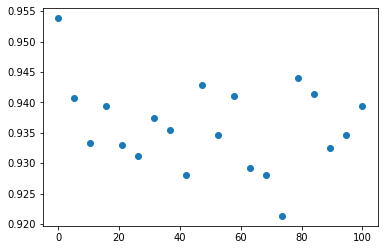

In [53]:
plt.scatter(df_plot_normal['param_C'], df_plot_normal['mean_test_acc'])

In [19]:
# data = []
for s in [100]:
    for cv in [2, 5]:
        df = run_grid(settings=s, cv=cv)
        data.append([s, cv, df['mean_test_acc'].max(), df])
        print(s, cv, df['mean_test_acc'].max())

100 2 0.9560508461508542
100 5 0.9741508636654501


In [18]:
df_summary = pd.DataFrame([(i, j, k) for i, j, k, m in data], columns=('settings', 'cv', 'score'))
print(df_summary.pivot('settings', 'cv', 'score').to_markdown())

|   settings |        2 |        5 |       10 |
|-----------:|---------:|---------:|---------:|
|          5 | 0.944102 | 0.973533 | 0.974625 |
|         10 | 0.94695  | 0.973705 | 0.974625 |
|         20 | 0.945184 | 0.97381  | 0.974625 |
|         50 | 0.951321 | 0.973705 | 0.974625 |


In [7]:
df = run_grid(settings=10, cv=5)

In [28]:
print(data[-1][-1][['rank_test_acc', 'param_C', 'mean_test_acc']].head(8).to_markdown())

|    |   rank_test_acc |   param_C |   mean_test_acc |
|---:|----------------:|----------:|----------------:|
|  7 |               1 |       0.8 |        0.974151 |
| 77 |               2 |       7.8 |        0.973705 |
| 50 |               3 |       5.1 |        0.973589 |
| 97 |               4 |       9.8 |        0.973512 |
|  0 |               5 |       0.1 |        0.973473 |
| 26 |               6 |       2.7 |        0.973414 |
| 75 |               7 |       7.6 |        0.973407 |
| 59 |               8 |       6   |        0.973329 |


Text(0, 0.5, 'mean test accuracy')

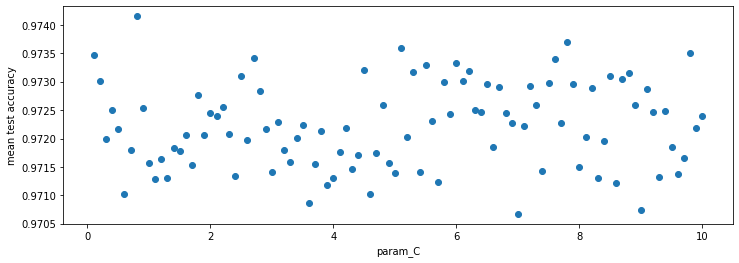

In [38]:
import matplotlib.pylab as plt

df_plot = data[-1][-1]

plt.figure(figsize=(12, 4))
plt.scatter(df_plot["param_C"], df_plot["mean_test_acc"])
plt.xlabel("param_C")
plt.ylabel("mean test accuracy")

<AxesSubplot:>

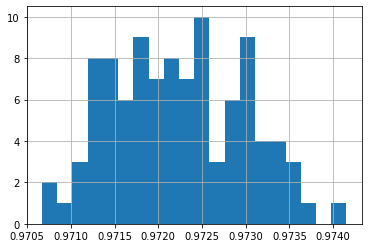

In [39]:
df['mean_test_acc'].hist(bins=20)